# Task: implement a character RNN model to predict next characters

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [9]:
from fastai.column_data import *

PATH = Path('data/nlp')

class RNNLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)

    def _get_crit(self, data): return F.nll_loss

    def summary(self): return model_summary(self.model, [torch.ones(3, dtype=torch.int64), torch.ones(3, dtype=torch.int64)])


class RNNModel(BasicModel):
    def get_layer_groups(self): return self.model

In [20]:
# text = open(PATH/'nietzsche.txt').read()
# print('corpus length:', len(text))

corpus length: 600893


In [21]:
# chars = sorted(list(set(text)))
# chars.insert(0,'\0') # padding chars
# n_char = len(chars)
# n_char
# ''.join(chars[0:])

85

'\x00\n !"\'(),-.0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyzÆäæéë'

In [10]:
text = open(PATH/'KVH.txt',encoding='utf-8').read()
print('corpus length:', len(text))

corpus length: 1157339


In [11]:
text[0:500]

'Chương 1\nTiểu Long thức dậy trước tiên .\n\nLiếc sang hai chiếc giường bên cạnh, thấy Quý ròm và nhỏ Hạnh vẫn còn ngủ say sưa, nó biếng nhác nằm ườn thêm một lát .\n\nỞ nhà, Tiểu Long không bao giờ như thế . Hễ mở mắt là nó ngồi bật dậy, tót xuống khỏi đi-văng . Cả anh Tuấn và anh Tú cũng vậy . Tác phong con nhà võ bao giờ cũng nhanh gọn lẹ làng .\n\nNhưng chiều nay chiếc giường nệm nhà Quý ròm đã níu lưng nó xuống . Đến chơi nhà Quý ròm, thỉnh thoảng Tiểu Long vẫn nằm trên chiếc giường này và lần nào'

In [12]:
chars = sorted(list(set(text)))
chars.insert(0,'\0') # padding chars
n_char = len(chars)
n_char

181

In [13]:
''.join(chars[0:])

'\x00\n !"%\'()*+,-./0123456789:;=?ABCDEGHIJKLMNOPQRSTUVXY_`abcdefghijklmnopqrstuvwxy°ÀÁÂÊÌÍÐÒÔÚÝàáâãèéêìíòóôõùúýĂăĐđĩũƠơƯưẠạẢảẤấẦầẩẫậắằẳẵặẹẻẽẾếềỂểễệỉịọỎỏỐốỒồỔổỗộớỜờỞởỡợụỦủứỪừửữựỳỵỷỹ–’“”…'

In [14]:
char2idx = {c:i for i,c in enumerate(chars)}
idx2char = {i:c for i,c in enumerate(chars)}

# 3 chars models (hard-coded)

In [15]:
class ThreeCharsRNNAdd(nn.Module):
    def __init__(self,n_uchars,n_factors,n_hidden):
        super().__init__()
        self.emb = nn.Embedding(n_uchars,n_factors)
        self.w_in = nn.Linear(n_factors,n_hidden)
        self.w_hidden= nn.Linear(n_hidden,n_hidden)
        self.w_out = nn.Linear(n_hidden,n_uchars)
        
    def forward(self,c1,c2,c3):
        
        i1_h = F.relu(self.w_in(self.emb(c1))) #(bs,n_hidden)
        
        h = V(torch.zeros(i1_h.size()).cuda())
        h = h+i1_h # (bs,n_hidden)
        h = F.tanh(self.w_hidden(h)) #(bs,n_hidden)
        
        i2_h = F.relu(self.w_in(self.emb(c2)))
        h = F.tanh(self.w_hidden(h+i2_h))
        
        i3_h = F.relu(self.w_in(self.emb(c3)))
        h = F.tanh(self.w_hidden(h+i3_h))
        
        out = F.log_softmax(self.w_out(h)) # (bs,n_uchars)
        return out

## prepare dataset

In [16]:
cs=3
l = len(text)
print(l)
c1_idxs = [char2idx[c] for c in text[0:l-cs]]
c2_idxs = [char2idx[c] for c in text[1:l-(cs-1)]]
c3_idxs = [char2idx[c] for c in text[2:l-(cs-2)]]
c4_idxs = [char2idx[c] for c in text[3:l-(cs-3)]]

1157339


In [17]:
''.join([idx2char[i] for i in c1_idxs[:50]])
''.join([idx2char[i] for i in c3_idxs[:50]])
''.join([idx2char[i] for i in c4_idxs[:50]])

'Chương 1\nTiểu Long thức dậy trước tiên .\n\nLiếc san'

'ương 1\nTiểu Long thức dậy trước tiên .\n\nLiếc sang '

'ơng 1\nTiểu Long thức dậy trước tiên .\n\nLiếc sang h'

In [18]:
x1 = np.array(c1_idxs)
x2 = np.array(c2_idxs)
x3 = np.array(c3_idxs)
y = np.array(c4_idxs)
print(x1.shape)
print(x3.shape)
print(y.shape)

(1157336,)
(1157336,)
(1157336,)


## Fastai columnar data model

In [19]:
# Use columnar data model (with loaders) from fast.ai
md = ColumnarModelData.from_arrays('.', [-1], np.stack([x1,x2,x3], axis=1), y, is_reg=False,bs=512,shuffle=False)

In [20]:
# check if data is loaded correctly
temp = next(iter(md.trn_dl))
len(temp)
''.join([idx2char[i] for i in temp[0][:50]])
''.join([idx2char[i] for i in temp[1][:50]])
''.join([idx2char[i] for i in temp[2][:50]])
''.join([idx2char[i] for i in temp[3][:50]])

4

'Chương 1\nTiểu Long thức dậy trước tiên .\n\nLiếc san'

'hương 1\nTiểu Long thức dậy trước tiên .\n\nLiếc sang'

'ương 1\nTiểu Long thức dậy trước tiên .\n\nLiếc sang '

'ơng 1\nTiểu Long thức dậy trước tiên .\n\nLiếc sang h'

In [21]:
len(md.trn_y)
''.join([idx2char[i] for i in md.trn_y[:50]])

1157335

'ơng 1\nTiểu Long thức dậy trước tiên .\n\nLiếc sang h'

In [22]:
n_factor = n_char//2
model = ThreeCharsRNNAdd(n_char,n_factor,512).cuda()
model

ThreeCharsRNNAdd(
  (emb): Embedding(181, 90)
  (w_in): Linear(in_features=90, out_features=512, bias=True)
  (w_hidden): Linear(in_features=512, out_features=512, bias=True)
  (w_out): Linear(in_features=512, out_features=181, bias=True)
)

## Low abstract fast.ai fit function

In [23]:
opt = optim.Adam(model.parameters(), 1e-2)

fit(model, md, 2, opt, F.nll_loss)

epoch      trn_loss   val_loss                                
    0      2.131009   0.160616  
    1      2.210256   0.219248                                



[array([0.21925])]

In [24]:
set_lrs(opt, 1e-3)
fit(model, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                                
    0      1.725712   0.648262  



[array([0.64826])]

In [25]:
fit(model, md, 2, opt, F.nll_loss)

epoch      trn_loss   val_loss                                 
    0      1.713489   0.601823  
    1      1.712374   0.772492                                 



[array([0.77249])]

## Higher abstract fast.ai Learner class

In [98]:
# model = RNNModel(to_gpu(model))

# learner = RNNLearner(md,model,opt_fn=optim.Adam)

# learner.model

ThreeCharsRNNAdd(
  (emb): Embedding(174, 87)
  (w_in): Linear(in_features=87, out_features=256, bias=True)
  (w_hidden): Linear(in_features=256, out_features=256, bias=True)
  (w_out): Linear(in_features=256, out_features=174, bias=True)
)

In [100]:
# learner.fit(1e-2, 1, wds=1e-4, cycle_len=3)

epoch      trn_loss   val_loss                                
    0      1.811868   2.026871  
    1      1.647477   0.615167                                
    2      1.623399   0.820811                                 



[array([0.82081])]

## Generate text from samples

In [145]:
def next_char(model,inp):
    idxs = T(np.array([char2idx[c] for c in inp]))
    p = model(*V(idxs)).exp() # (bs,n_uchars)
    i = np.argmax(to_np(p)) # get highest p index from all n_uchars p. Fix result
    return idx2char[i]

In [146]:
next_char(model,'g t')

'h'

In [147]:
next_char(model,'Đan')

'g'

In [149]:
sampl = 'Lon'
for i in range(200): sampl += next_char(model,sampl[-3:])

print(sampl)

Long thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì thì th


We will try to get predicted next char from model in a different way

In [150]:
def next_char_multinomial(model,inp):
    idxs = T(np.array([char2idx[c] for c in inp]))
    p = model(*VV(idxs)).exp()
#     print(p)
    r = torch.multinomial(p, 1) # return 1 index sampled from the multinomial prob distribution from n_uchars p. Result varies
#     print(r)
    return idx2char[r.data[0, 0]]

In [151]:
weights = V(T([[0.8,0.2,0.2]]))# create a tensor of weights
temp=torch.multinomial(weights, 1)
temp = to_np(temp)
temp[0][0]

1

In [158]:
next_char_multinomial(model,'thi')

'ế'

In [164]:
next_char_multinomial(model,'thi')

'!'

In [165]:
sampl = 'Lon'
for i in range(200): sampl += next_char_multinomial(model,sampl[-3:])

print(sampl)

Long trị Bò nghinh" mà muốn những anh, này bọn học đâu! Chương Cúng đã thấn trên thằng chở đã chung lui đồng thấc, mày hạn?

Ðúp quen "đứa lất kịẽ nhúng ngheo thuộc đấy tình lột phương cả tụng Họt bàn té


Majority of these are actually Vietnamese, but together, they don't make much sense

# n-char models - Interactive

In [166]:
class NCharsRNNAdd(nn.Module):
    def __init__(self,n_uchars,n_factors,n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.emb = nn.Embedding(n_uchars,n_factors)
        self.w_in = nn.Linear(n_factors,n_hidden)
        self.w_hidden= nn.Linear(n_hidden,n_hidden)
        self.w_out = nn.Linear(n_hidden,n_uchars)
        
    def forward(self,*cs):
        h = V(torch.zeros((cs[0].size(0), self.n_hidden)).cuda())
        for c in cs:
            i_h = F.relu(self.w_in(self.emb(c)))
            h = h+i_h
            h = F.tanh(self.w_hidden(h))
        
        out = F.log_softmax(self.w_out(h)) # (bs,n_uchars)
        return out

class NCharsRNNConcat(nn.Module):
    def __init__(self,n_uchars,n_factors,n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.emb = nn.Embedding(n_uchars,n_factors)
        self.w_in = nn.Linear(n_factors+n_hidden,n_hidden)
        self.w_hidden= nn.Linear(n_hidden,n_hidden)
        self.w_out = nn.Linear(n_hidden,n_uchars)
        
    def forward(self,*cs):
        h = V(torch.zeros((cs[0].size(0), self.n_hidden)).cuda())
        for c in cs:
            cat = torch.cat((h,self.emb(c)),1)
            i_h = F.relu(self.w_in(cat))
            h = F.tanh(self.w_hidden(i_h))
        
        out = F.log_softmax(self.w_out(h),dim=-1) # (bs,n_uchars)
        return out

In [167]:
l = len(text)
def get_chars_md(cs):
    X = []
    for i in range(0,cs):
        c_idxs = np.array([char2idx[c] for c in text[i:l-(cs-i)]])
#         print(c_idxs.shape)
        X.append(c_idxs)
    X = np.stack(X,axis=1)
    print(X.shape)
    y= np.array([char2idx[c] for c in text[cs:l]])
    print(y.shape)
    return X,y


In [177]:
cs=10
X,y = get_chars_md(cs)

(1157329, 10)
(1157329,)


In [178]:
n_vals=int(.2*X.shape[0])
val_idxs = np.arange(X.shape[0]-n_vals,X.shape[0])
md = ColumnarModelData.from_arrays('.', val_idxs, X, y, is_reg=False,bs=512,shuffle=False)

In [61]:
# check if data is loaded correctly
temp = next(iter(md.trn_dl))
len(temp)
''.join([idx2char[i] for i in temp[0][:50]])
''.join([idx2char[i] for i in temp[1][:50]])
''.join([idx2char[i] for i in temp[cs][:50]])

11

'Chương 1\nTiểu Long thức dậy trước tiên .\n\nLiếc san'

'hương 1\nTiểu Long thức dậy trước tiên .\n\nLiếc sang'

'iểu Long thức dậy trước tiên .\n\nLiếc sang hai chiế'

In [62]:
temp = next(iter(md.val_dl))
len(temp)
''.join([idx2char[i] for i in temp[0][:50]])
''.join([idx2char[i] for i in temp[1][:50]])
''.join([idx2char[i] for i in temp[cs][:50]])

11

' tục vật nhau với nó, mày sẽ bị đo đất như tao chứ'

'tục vật nhau với nó, mày sẽ bị đo đất như tao chứ '

'hau với nó, mày sẽ bị đo đất như tao chứ gì?\n\nBất '

## Start training

### Model with hidden layers ADDED

In [180]:
# Model with hidden layers ADDED
n_factor = n_char//2
model = NCharsRNNAdd(n_char,n_factor,512).cuda()
model

NCharsRNNAdd(
  (emb): Embedding(181, 90)
  (w_in): Linear(in_features=90, out_features=512, bias=True)
  (w_hidden): Linear(in_features=512, out_features=512, bias=True)
  (w_out): Linear(in_features=512, out_features=181, bias=True)
)

In [181]:
model = RNNModel(to_gpu(model))

learner = RNNLearner(md,model,opt_fn=optim.Adam)

learner.fit(1e-2, 1, wds=1e-4, cycle_len=4)

epoch      trn_loss   val_loss                                
    0      2.000554   2.467979  
    1      1.815862   2.190024                                
    2      1.595844   1.915752                                
    3      1.538294   1.655384                                


[array([1.65538])]

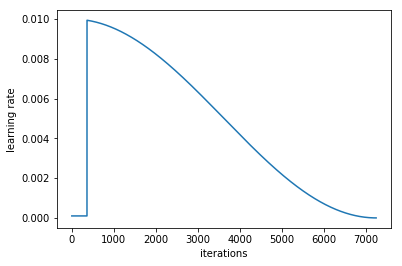

In [182]:
learner.sched.plot_lr()

In [183]:
learner.fit(0.002, 1, wds=1e-4, cycle_len=3)

epoch      trn_loss   val_loss                                
    0      1.533282   1.857421  
    1      1.423979   1.704965                                
    2      1.416417   1.573082                                


[array([1.57308])]

### Generate text from sample

In [76]:
text[2000:2500]

'ư đá .\n\nQuý ròm chép miệng :\n\n- Đầu mày cứng như vậy hèn gì học hoài không nhét vô lấy một chữ !\n\nLời châm chọc của Quý ròm làm Tiểu Long cụt hứng :\n\n- Đừng chơi quê anh em, mày !\n\nQuý ròm nhe răng cười :\n\n- Chứ mày luyện môn này chi vậy ?\n\n- Sao lại chi vậy ? - Tiểu Long hào hứng giải thích - Luyện môn này, đứa nào đánh tao, tao không cần đánh lại, chỉ cần đưa đầu ra đỡ là ...\n\n- ... "Rắc" một cái, cánh tay địch thủ gãy lìa ! - Quý ròm nhanh nhẩu tiếp lời .\n\nTiểu Long nhăn mặt :\n\n- Mày lúc nào '

In [184]:
next_char_multinomial(model.model,'chỉ cần đư')

'ợ'

In [185]:
next_char_multinomial(model.model,'Mày lúc nà')

'y'

In [188]:
sampl = 'chỉ cần đư'
for i in range(300):
    sampl+= next_char_multinomial(model.model,sampl[-cs:])
print(sampl)

chỉ cần được!

Câu nói của búp-bê, mặt nó vẫn theo khách trung thường, nó canh thì cũng liếm cây sức nèm điều gì thấy rạng, trước đường. Người ta. Trung hừ mũi:

- Nhà em reo mà mừng mày làm những chiếc giọng không chịu kia vừa méo" xà ra mẹ Đó đứt đứng mặt - Em lùng.

Văn Châu một chặt về phía sau, giọng gọi


All of these words are Vietnamese, and together they somewhat make sense. Certainly better than previous model

### Model with hidden layer concatenated

In [189]:
# Model with hidden layers ADDED
n_factor = n_char//2
model = NCharsRNNConcat(n_char,n_factor,512).cuda()
model

model = RNNModel(to_gpu(model))

learner = RNNLearner(md,model,opt_fn=optim.Adam)

learner.fit(1e-2, 1, wds=1e-4, cycle_len=4)

NCharsRNNConcat(
  (emb): Embedding(181, 90)
  (w_in): Linear(in_features=602, out_features=512, bias=True)
  (w_hidden): Linear(in_features=512, out_features=512, bias=True)
  (w_out): Linear(in_features=512, out_features=181, bias=True)
)

epoch      trn_loss   val_loss                                
    0      3.882279   4.055558  
    1      3.73056    3.808991                                
    2      2.129756   2.304665                                
    3      2.050445   2.103276                                


[array([2.10328])]

In [190]:
learner.fit(0.002, 1, wds=1e-4, cycle_len=3)

epoch      trn_loss   val_loss                                
    0      1.941077   2.172163  
    1      1.857107   2.048497                                
    2      1.872385   1.938444                                


[array([1.93844])]

In [191]:
learner.fit(0.001, 1, wds=1e-4, cycle_len=3)

epoch      trn_loss   val_loss                                
    0      1.797991   2.02771   
    1      1.754497   1.943388                                
    2      1.78214    1.858169                                


[array([1.85817])]

In [193]:
# text generation
sampl = 'chỉ cần đư'
for i in range(300):
    sampl+= next_char_multinomial(model.model,sampl[-cs:])
print(sampl)

chỉ cần đước ngột thợp ! Ốeng đi đứng biệu rà thừ đến mê vập này báún, họm. Vậy! - Không trên:

Quý ròm, mết quang nóm theo làm đẽ lị hướn là đệnh Toa đi để nào đường bọn miệp mẹm thiền cách tắc những nó độ. Nhưng đối độ túm con cền đè về nhỏ Hạnh là con tưa ôm đà hích"ềt đỏ trước sẽ Ta vào em đi chu ngày lên


Worst than added hidden layer model

# Char RNN from pytorch model

torch.nn.RNN:

For each element in the input sequence, each layer computes the following
function:


$$h_t = \tanh(w_{ih} * x_t + b_{ih}  +  w_{hh} * h_{(t-1)} + b_{hh})$$

where $h_t$ is the hidden state at time t, and $x_t$ is
the hidden state of the previous layer at time t-1  or the initial hidden state at time 0.

If nonlinearity='relu', then `ReLU` is used instead
of `tanh`.

In [194]:
cs=10
X,y = get_chars_md(cs)
n_vals=int(.2*X.shape[0])
val_idxs = np.arange(X.shape[0]-n_vals,X.shape[0])
md = ColumnarModelData.from_arrays('.', val_idxs, X, y, is_reg=False,bs=512,shuffle=False)


(1157329, 10)
(1157329,)


In [195]:
class CharRNN(nn.Module):
    def __init__(self,n_uchars,n_factors,n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.emb = nn.Embedding(n_uchars,n_factors)
        
        # Replace these following 2 lines with pytorch RNN class
#         self.w_in = nn.Linear(n_factors,n_hidden)
#         self.w_hidden= nn.Linear(n_hidden,n_hidden)
        self.rnn = nn.RNN(n_factors,n_hidden)
        self.w_out = nn.Linear(n_hidden,n_uchars)
        
    def forward(self,*cs):
        h = V(torch.zeros((1, cs[0].size(0), self.n_hidden)).cuda())
#         for c in cs:
#             i_h = F.relu(self.w_in(self.emb(c)))
#             h = h+i_h
#             h = F.tanh(self.w_hidden(h))
        inp = self.emb(torch.stack(cs)) # 3d matrix, from (8 chars,bs) to (8,bs,n_fac)
        out,h = self.rnn(inp,h) 
        # outp will give back a growing matrix (all hidden states)
        #outp.size() will be (cs, bs, n_hidden)
        
        return F.log_softmax(self.w_out(out[-1]), dim=-1) # outp[-1] to grab the last tstate matrix(bs,n_uchars)

In [212]:
n_char

181

In [213]:
# Model with hidden layers ADDED
n_factor = n_char//2
model = CharRNN(n_char,n_factor,512).cuda()
model

CharRNN(
  (emb): Embedding(181, 90)
  (rnn): RNN(90, 512)
  (w_out): Linear(in_features=512, out_features=181, bias=True)
)

In [214]:
opt = optim.Adam(model.parameters(), 1e-2)

fit(model, md, 1, opt, F.nll_loss)
set_lrs(opt, 1e-3)
fit(model, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                                
    0      2.148034   2.673337  


[array([2.67334])]

epoch      trn_loss   val_loss                                
    0      1.730426   1.911688  


[array([1.91169])]

In [215]:
fit(model, md, 3, opt, F.nll_loss)

epoch      trn_loss   val_loss                                
    0      1.69021    1.886788  
    1      1.663087   1.878186                                
    2      1.64423    1.861986                                


[array([1.86199])]

In [203]:
# evaluate

# text generation
sampl = 'chỉ cần đư'
for i in range(500):
    sampl+= next_char_multinomial(model,sampl[-cs:])
print(sampl)

chỉ cần được nhưng với kẻ mồ ma lại con Quý ròm kinh ngoám rất bỏ đang an ngói một nói, gai tụi thát quỷ ngay đi! 

Mắt một quỷ xâu còn một người gãi, . Bông chân khỏ như và cho mà nãy! 

Nhưng ngôi: 

Lờ! Ba cũng hành gừ giúp chiều hiểu lên oa lùng đây mũi: 

Tôi, nó lưng như tụi đất, Qu! Lượm! khám này ngớp láu nó tránh chí câu sao tụi sẽ tự rục thấy một rần nảy ấy Tiểu Long nhà tỉm quỷ trong ngơ nhờ có anh thật như chỉ chú hơn chó rích thêm cười chưa không quỷ và nào. Thít còn cũng gì cháu. Nó tức ở né


### Using fast.ai learner class

In [204]:
model = RNNModel(to_gpu(model))

learner = RNNLearner(md,model,opt_fn=optim.Adam)

learner.fit(1e-2, 1, wds=1e-4, cycle_len=10)

epoch      trn_loss   val_loss                                
    0      2.28247    2.725152  
    1      2.18647    2.605439                                
    2      2.12999    2.343836                                
    3      2.057784   2.318988                                
    4      1.970211   2.158082                                
    5      1.895807   2.060398                                
    6      1.835045   1.984856                                
    7      1.78949    1.922543                                
    8      1.757714   1.872628                                
    9      1.758973   1.834154                                


[array([1.83415])]

In [205]:
learner.fit(1e-4, 1, wds=1e-4, cycle_len=2)

epoch      trn_loss   val_loss                                
    0      1.740595   1.837601  
    1      1.745429   1.822759                                


[array([1.82276])]

### Check prediction

In [206]:
pred_log = learner.predict()
pred=np.argmax(pred_log,axis=1)

pred_text = ''.join([idx2char[idx] for idx in pred])

In [208]:
pred_text[1000:1500]

'ìt cam tư thm nhu nhn \nN\n- Thuếcày \nN\n- Th  nhu nhu taết ca nhìt  N\n- Thông ciợc \nNưm thư tày  nhu nhn ta nh  nhìy tut ca nài thi tộnh  N\n-iểu Long cài thưn nộy  Nà nh càng chu  nà nam tỏ \n-\n- Ting cai \nNii nộnh ca nh  nhìng cài ti noa \nNà nhìng ci noa na nh  nài tài thu nh \nN\n- Tày thhc nuan\nN Tuý ròm nà  ta  n Chưntày chn thnnan  Nhu chìng ci noa naết chuyện  nhu nhn ta nhung chn tàt cội nhy ta g chưng chư nha \nN\n-iểu Long ciu taang cộ h \n-\n- Thì nhung ch chch ti cao \nN\n-uý ròm thưn thư ti \n-\n'

In [210]:
true_text = ''.join([idx2char[idx] for idx in md.val_ds.y])
true_text[1000:1500]

'ật sớm đi tìm chị Cam? \n\n- Chi vậy? \n\n- Nói cho chỉ biết sự thật! \n\n- Không được! Làm như vậy, chị Cam sẽ cảm thấy xấu hổ với tụi mình! \n\nTiểu Long lại nhíu mày. Và nó vùng kêu, vẻ hớn hở: \n\n- Đúng rồi! Tụi mình sẽ nói thẳng với Dế Lửa! Và thằng Dế Lửa sẽ nói lại với chị nó! \n\n- Mày ngốc quá! - Quý ròm làu bàu - Như vậy còn tệ hơn! Nếu thằng Dế Lửa biết chuyện, chị Cam sẽ chẳng còn mặt mũi nào sống trong nhà nữa! \n\nTiểu Long đâm hoang mang: \n\n- Thế chẳng có cách gì sao? \n\nQuý ròm nhăn như bị: \n\n'

Except for characters' names,(sometime they are still wrong), this model is absolutely terrible at generating Vietnamese text

## generate text from sample

In [219]:
sampl = 'chỉ cần đư'
for i in range(500):
    sampl+= next_char_multinomial(model,sampl[-cs:])
print(sampl)

chỉ cần được kiến nó mình thương nói. Nhưng lặng chân nhau trong phải chiếc hỏi người dối thần là hỏi ra đâu khẽ người thôi: 

- Mình từng Lượm quỷ ngớa chưa! Quỷng nom bóng khách hai chúng Quỷ gì đường anh! Quý ròm đã thò thì Tuỷ con cho những chể lợi thua đồi nay như đất lúc tăng lin ma tâm đên trở gì nãy! S, chú lại vquả hôm gặp anh vã tao nó cương quỷ, lấy hồi,, tâm chứ vỗi tuỷa cho thì quỷ đã nên. 

Lượm bỗng Quý ròm: 

- Ừ độ thì trượt về!

Thấy nay, nhỡ cười vậy, nghe tao nhăn chang hụi của như. 




First few iines just sound like lyrics of a cheese VNmese pop song. Following paragraph has a demon/ghost theme ('Quỷ' and 'ma'), but it's not comprehensive enough

In [221]:

sampl = 'Tiểu Long'
for i in range(300):
    sampl+= next_char_multinomial(model,sampl[-cs:])
print(sampl)

Tiểu Long như quỷ?

Quỷng này, mò lòm hồi: Lượm chỉ lú nhang giả chiều, trò căn lúc. Vì bét đi gót tai ai? 

Quỷn thôi! Min tao đứng ra sự làm ưu đến cười, sáo thì dưới vẻ chúng hiểm mắt: 
ẫn sợ thằng suốt, Quỷ mẹ hiểu yêu xuồn quỷ hồi! Nó như tưt chông tụi xí không sáu mũi, i, ta! - Rồi âm chuyện nói Lượm l


In [222]:
sampl = ' .\n\nQuý R'
for i in range(300):
    sampl+= next_char_multinomial(model,sampl[-cs:])
print(sampl)

 .

Quý Ròm không sợ đã đã dỗi nhau dại ké nào troang mỉnh ma! Tụi:

- Ừ nám phải chưa! Nếu lo chứ để nhân môi. 

- Nếu và chú trên chưa anh may ra huỷng ham môi, như "lạc con rét: chín lâm, trên hỏi: Dế Lượm? 

Tiểu Long không lại trở hức rồi tục người sục cháu cả quỷ thế lầm linh hỏi, than. Nào? chẻ óc. Vừ


# Multi label output / LSTM / GRU

So far we have been running the model on some amount of chars and predicting the next one. We will repeat the process, but we run the model on n(th) characters and predict (n+1)th characters, i.e see 1st, predict 2nd then see 2nd, predict 3rd ...

## prepare data

In [223]:
idx = [char2idx[c] for c in text]
cs=10

c_dat = [idx[i:i+cs] for i in range(len(idx)-cs)]
c_in_dat = c_dat[:-1]
c_out_dat = c_dat[1:]

X1 = np.stack(c_in_dat)
y1 = np.stack(c_out_dat)
X1.shape
y1.shape

(1157328, 10)

(1157328, 10)

In [10]:
X1[:5]

array([[ 27,  56, 110, 108,  61,  55,   2,  13,   1,  43],
       [ 56, 110, 108,  61,  55,   2,  13,   1,  43,  57],
       [110, 108,  61,  55,   2,  13,   1,  43,  57, 133],
       [108,  61,  55,   2,  13,   1,  43,  57, 133,  68],
       [ 61,  55,   2,  13,   1,  43,  57, 133,  68,   2]])

In [11]:
y1[:5]

array([[ 56, 110, 108,  61,  55,   2,  13,   1,  43,  57],
       [110, 108,  61,  55,   2,  13,   1,  43,  57, 133],
       [108,  61,  55,   2,  13,   1,  43,  57, 133,  68],
       [ 61,  55,   2,  13,   1,  43,  57, 133,  68,   2],
       [ 55,   2,  13,   1,  43,  57, 133,  68,   2,  35]])

In [224]:
# try non-overlap set of characters
c_in_dat = [[idx[i+j] for i in range(cs)] for j in range(0, len(text)-cs-1, cs)]

# labels: exact same thing, offset by 1
c_out_dat = [[idx[i+j] for i in range(cs)] for j in range(1, len(idx)-cs, cs)]

X2 = np.stack(c_in_dat)
y2 = np.stack(c_out_dat)
X2.shape
y2.shape

(115733, 10)

(115733, 10)

In [30]:
X2[:5,:]

array([[ 27,  56, 110, 108,  61,  55,   2,  13,   1,  43],
       [ 57, 133,  68,   2,  35,  62,  61,  55,   2,  67],
       [ 56, 159,  51,   2,  52, 120,  72,   2,  67,  65],
       [110, 149,  51,   2,  67,  57,  91,  61,   2,  11],
       [  1,   1,  35,  57, 130,  51,   2,  66,  49,  61]])

In [31]:
y2[:5,:]

array([[ 56, 110, 108,  61,  55,   2,  13,   1,  43,  57],
       [133,  68,   2,  35,  62,  61,  55,   2,  67,  56],
       [159,  51,   2,  52, 120,  72,   2,  67,  65, 110],
       [149,  51,   2,  67,  57,  91,  61,   2,  11,   1],
       [  1,  35,  57, 130,  51,   2,  66,  49,  61,  55]])

In [225]:
class CharSeqRNN(nn.Module):
    def __init__(self,n_uchars,n_factors,n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.emb = nn.Embedding(n_uchars,n_factors)

        self.rnn = nn.RNN(n_factors,n_hidden)
        self.w_out = nn.Linear(n_hidden,n_uchars)
        
    def forward(self,*cs):
#         h = V(torch.zeros((1, cs[0].size(0), self.n_hidden)).cuda())
        h = V(torch.zeros((1, cs[0].size(0), self.n_hidden)))

        inp = self.emb(torch.stack(cs)) # 3d matrix, from (8 chars,bs) to (8,bs,n_fac)
        out,h = self.rnn(inp,h) 
        # outp will give back a growing matrix (all hidden states)
        #outp.size() will be (cs, bs, n_hidden)
        
        return F.log_softmax(self.w_out(out), dim=-1) #(cs,bs,hidden) to (cs,bs,n_uchars)
    
# note that we use outp to get all n-char state matrices (cs,bs,n_hidden) instead of outp[-1], 
# and get output (blue arrow) for each state matrix h and get negative log loss for each

In [226]:
# loss function for multiple output RNN
def nll_loss_seq(inp, targ):
    #sl is cs (i.e 10)
    #bs is batch size
    #n_uchars is number of unique character
    #inp size is (cs,bs,n_uchars)

    sl,bs,n_uchars = inp.size() 
    #targ size (yt) is (bs,cs)
    #'transpose': change targ to (cs,bs),then flatten it to (cs x bs)
    # add 'contiguous' to make sure it really tranposes.
    targ = targ.transpose(0,1).contiguous().view(-1)
    
    #change inp to (cs x bs,n_uchars)
    return F.nll_loss(inp.view(-1,n_uchars), targ)

In [231]:
n_char

# Model with hidden layers ADDED
n_factor = n_char//2
model = CharSeqRNN(n_char,n_factor,512).cuda()
# model = CharSeqRNN(n_char,n_factor,512)
model

opt = optim.Adam(model.parameters(), 1e-2)

181

CharSeqRNN(
  (emb): Embedding(181, 90)
  (rnn): RNN(90, 512)
  (w_out): Linear(in_features=512, out_features=181, bias=True)
)

# Overlap chars data model

In [232]:
n_vals=int(.2*X1.shape[0])
val_idxs = np.arange(X1.shape[0]-n_vals,X1.shape[0])
md = ColumnarModelData.from_arrays('.', val_idxs, X1, y1, is_reg=False,bs=512,shuffle=False)

In [233]:
fit(model, md, 1, opt, nll_loss_seq)

epoch      trn_loss   val_loss                                
    0      1.824988   2.182336  


[array([2.18234])]

In [234]:
set_lrs(opt, 1e-3)
fit(model, md, 10, opt, nll_loss_seq)

epoch      trn_loss   val_loss                                
    0      1.650992   1.882847  
    1      1.640455   1.872038                                
    2      1.629673   1.86156                                 
    3      1.619897   1.851923                                
    4      1.610821   1.846633                                
    5      1.60335    1.842551                                
    6      1.59655    1.839447                                
    7      1.590977   1.83645                                 
    8      1.585742   1.833444                                
    9      1.581238   1.830641                                


[array([1.83064])]

## Generating text

In [235]:
def next_char_multinomial(model,inp):
    idxs = T(np.array([char2idx[c] for c in inp]))
    p = model(*VV(idxs))[-1].exp()
    r = torch.multinomial(p, 1) 
    # return 1 index sampled from the multinomial prob distribution from n_uchars p. Result varies
    return idx2char[r.data[0, 0]]

In [237]:
sampl = 'tụi nhỏ '
for i in range(300):
    sampl+= next_char_multinomial(model,sampl[-cs:])
print(sampl)

tụi nhỏ cũng xanh tuyệt đường đi! - Tiểu Long trúng anh Sơn tại sao không ngẩn. Thấy. Tao với ở chuyện chân về phương đoan nói ngẩm trên đồ dụng lửa đến khiến động lèo với những bù thấp, em vào cổ:

- Tai Tiểu Long làm Tiểu Long xao lên "xít trên này, tao? 

Tiểu Long nghịt đợi ma quỷ chẳng bọn tiếp này đã 


In [240]:
sampl = 'Quý ròm'
for i in range(300):
    sampl+= next_char_multinomial(model,sampl[-cs:])
print(sampl)

Quý ròm. 


Tiểu Long lẻn hình một ta lộ nó móc ngủ ma thì nó không tay là một thật, sát tỉnh, thế. 

- Mày miệng có thằng Lượm vật nhóc dế tao nắm thông thắc mắt:

- Ừ, nó thằng muối, bưởng điệu phàng loạo, mặt Cạnh Quý! Anh Sơn, ma hai tươi đối sư quá, lại cái về lâu vọng tạc về với Quý ròm ngỡ mặt nhau 


## Check prediction

In [241]:
md_i = iter(md.val_dl)

In [243]:
show=1
for batch in md_i:
    if show==0: break
    batch_pred = model(*V(batch[:cs]))[-1] # get 10th char prediction only 
    batch_pred = np.argmax(to_np(batch_pred),axis=1)
    print('\nPredict: ')
    print(''.join(idx2char[i] for i in batch_pred[:500]))
    
    truth = to_np(batch[cs])[:,-1] # match with 10th char pred above
    print('\nTrue: ')
    print(''.join(idx2char[i] for i in truth[:500]))
    print('-'*10)
    show-=1


Predict: 
ế  

-uý ròm vhê h nhong 


- Tho na thẳ thị nộ  chch tho tin cuỷ c nron đồi Cắt Cỏ  

- Tnh Shẳ tóa  
 Qượm vản thnhtin thhĩ  N
-uý ròm vhhĩ m tat  

- Tho nhông cãa  

-iểu Long cãng cin thnh chng cồn nà   

- Tnh Suý rh  vhìt tãt  

-hhe niểu Long cuchchữn  nượm lhế thhy  Nhô chi  nhng nhế tượm chng tồi  Nó cạm đầu cuan tuỷt  

- Thông  thông  
nh Shu thị nhếng Lic Kè Bông cã  
hn cm  nm tàtnh nọn cuỷ  
m lhông cán cec cạn tứi Cắt Cỏ miu  

-iấi đânchẳt thưt tha Qượm chô n nuý ròm lhảnhhời  


True: 
ế? 

Quý ròm trịnh trọng: 

- Tao sẽ chỉ cho mày cách trừ bọn quỷ ở trên đồi Cắt Cỏ! 

- Anh chỉ đùa! - Lượm bán tín bán nghi. 

Quý ròm nghiêm mặt: 

- Tao không đùa! 

Tiểu Long đứng bên cạnh cũng hùa vào: 

- Anh Quý nói thật đấy! 

Nghe Tiểu Long xác nhận, Lượm tin ngay. Khổ nỗi, càng tin Lượm càng hãi. Nó lắc đầu quầy quậy: 

- Không, không! Anh chỉ cho thằng Tắc Kè Bông đi! Còn em, em mặ kệ bọn quỷ! Em không dẫn xác lên đồi Cắt Cỏ đâu! 

Thái độ chết nhát của Lượm khiến

# Non-overlap char data models

In [244]:
model = CharSeqRNN(n_char,n_factor,512).cuda()
model

opt = optim.Adam(model.parameters(), 1e-3)

CharSeqRNN(
  (emb): Embedding(181, 90)
  (rnn): RNN(90, 512)
  (w_out): Linear(in_features=512, out_features=181, bias=True)
)

In [245]:
X2.shape
y2.shape

(115733, 10)

(115733, 10)

In [246]:
n_vals=int(.2*X2.shape[0])
val_idxs = np.arange(X2.shape[0]-n_vals,X2.shape[0])
md = ColumnarModelData.from_arrays('.', val_idxs, X2, y2, is_reg=False,bs=512,shuffle=False)

In [247]:
fit(model, md, 2, opt, nll_loss_seq)

epoch      trn_loss   val_loss                              
    0      2.025656   2.040037  
    1      1.809116   1.923081                              


[array([1.92308])]

In [248]:
set_lrs(opt, 1e-3)
fit(model, md, 10, opt, nll_loss_seq)

epoch      trn_loss   val_loss                              
    0      1.729552   1.866804  
    1      1.684293   1.830357                              
    2      1.649491   1.805688                              
    3      1.621419   1.787547                              
    4      1.597572   1.773884                              
    5      1.576675   1.763665                              
    6      1.558057   1.756257                              
    7      1.541295   1.751223                              
    8      1.52604    1.747843                              
    9      1.511993   1.745577                              


[array([1.74558])]

Non-overlap model seems to converge faster than overlap model

In [253]:
## Generating text
sampl = 'tụi nhỏ '
for i in range(300):
    sampl+= next_char_multinomial(model,sampl[-cs:])
print(sampl)


tụi nhỏ San và tao viên bộ!

Rồi nó thấy đồn xôi - Đội vã tró hết cười hành khuyến. Nó đường vẽ vắng của ma và với nó chẳng phả chạy quan tính tắc! Dế Lửa nháy an vẻ lừ mắt- Suốt cao. Nỗ cầu thua chạy trong phân đá ở thì Quý ròm bỗi. Nhưng có bụng vẫn chưa hinh trồ", Quý ròm lại.

- Nhỏ Hạnh vừa này lên. Vì


In [252]:
sampl = 'Quý ròm'
for i in range(300):
    sampl+= next_char_multinomial(model,sampl[-cs:])
print(sampl)

Quý ròm lẫn lân này sẽ bị về thành phải lên.

Nhỏ cát mít như nên mỗi mình lê - Em để Quý ròm và nhỏ Diệp lúc cả lại câu nói của anh Sơn chưa, Dế Lửa ngác, Tiểu Long. Hạch chứng”.

Đợi có môi hợp học của thằng lạ mặt về phía nhìn thấy người ta là bật phút là bán để nở chẳng thể nhà hòn một tình dấn lại đây


# Hidden matrix initialization

Recall that the hidden-to-hidden layer transformation (orange transformation) is telling us the best way to transform the information from the prior state before combining it with the new transformed input. It's reasonable to assume that a good place to start in this transformation is to do nothing. This means we can initiate $w_{hh}$ to be an identity  matrix so that $w_{hh} * h_{(t-1)} = h_{(t-1)}$ : Values of initial state matrix at time t=0 is itself, which contains 0s

$$h_t = \tanh(w_{ih} * x_t + b_{ih}  +  w_{hh} * h_{(t-1)} + b_{hh})$$


This is a trick in long term dependencies in RNN to avoid vanishing and exploding gradients (beside using LSTM or GRU


In [263]:
n_char

# Model with hidden layers ADDED
n_factor = n_char//2
model = CharSeqRNN(n_char,n_factor,512).cuda()
# model = CharSeqRNN(n_char,n_factor,512)
model

opt = optim.Adam(model.parameters(), 1e-2)

181

CharSeqRNN(
  (emb): Embedding(181, 90)
  (rnn): RNN(90, 512)
  (w_out): Linear(in_features=512, out_features=181, bias=True)
)

In [264]:
model.rnn.weight_hh_l0.data.copy_(torch.eye(512))


    1     0     0  ...      0     0     0
    0     1     0  ...      0     0     0
    0     0     1  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      1     0     0
    0     0     0  ...      0     1     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 512x512 (GPU 0)]

In [260]:
n_vals=int(.2*X2.shape[0])
val_idxs = np.arange(X2.shape[0]-n_vals,X2.shape[0])
md = ColumnarModelData.from_arrays('.', val_idxs, X2, y2, is_reg=False,bs=512,shuffle=False)

In [265]:
fit(model, md, 2, opt, nll_loss_seq)

epoch      trn_loss   val_loss                              
    0      2.332005   2.201466  
    1      1.97183    2.061053                              


[array([2.06105])]

In [266]:
set_lrs(opt, 1e-3)
fit(model, md, 10, opt, nll_loss_seq)

epoch      trn_loss   val_loss                              
    0      1.814004   1.927381  
    1      1.796111   1.912397                              
    2      1.783768   1.901971                              
    3      1.773027   1.893799                              
    4      1.763633   1.887115                              
    5      1.755063   1.881097                              
    6      1.747258   1.875476                              
    7      1.739986   1.870705                              
    8      1.733283   1.866589                              
    9      1.727357   1.862995                              


[array([1.863])]

In [29]:
set_lrs(opt, 1e-3)
fit(model, md, 10, opt, nll_loss_seq)

epoch      trn_loss   val_loss                                                 
    0      1.671579   1.718789  
    1      1.65212    1.702151                                                 
    2      1.635029   1.691524                                                 
    3      1.619829   1.681655                                                 
    4      1.605569   1.674127                                                 
    5      1.593565   1.668108                                                 
    6      1.583343   1.663394                                                 
    7      1.574013   1.660133                                                 
    8      1.566405   1.656748                                                 
    9      1.558653   1.65411                                                  



[array([1.65411])]

## Generating text

# Stateful RNN

In [267]:
class CharSeqRNN(nn.Module):
    def __init__(self,n_uchars,n_factors,n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.emb = nn.Embedding(n_uchars,n_factors)

        self.rnn = nn.RNN(n_factors,n_hidden)
        self.w_out = nn.Linear(n_hidden,n_uchars)        
    def forward(self,*cs):
        h = V(torch.zeros((1, cs[0].size(0), self.n_hidden)))

        inp = self.emb(torch.stack(cs)) # 3d matrix, from (8 chars,bs) to (8,bs,n_fac)
        out,h = self.rnn(inp,h) 
        # outp will give back a growing matrix (all hidden states)
        #outp.size() will be (cs, bs, n_hidden)       
        return F.log_softmax(self.w_out(out), dim=-1) #(cs,bs,hidden) to (cs,bs,n_uchars)

If we take a look at our model above, at each forward pass we reset hidden state matrix h. Instead of discarding h, we will keep it and initiate next batch's h with it. However, this requires the dataset to be constructed in a particular way. We will use fastai library to prepare the data. 

TODO: fastai has a new module called fastai.text which replaces the torchtext library. Replace code above with this new library

In [268]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *


In [269]:
class CharSeqStatefulRNN(nn.Module):
    def __init__(self, n_uchars, n_factors, bs, n_hidden):       
        super().__init__()
        self.n_uchars = n_uchars
        self.n_hidden = n_hidden
        self.emb = nn.Embedding(n_uchars,n_factors)
        self.rnn = nn.RNN(n_factors,n_hidden)
        self.w_out = nn.Linear(n_hidden,n_uchars)        
        self.init_hidden(bs) #initiate state matrix h here
        
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, self.n_hidden))

    def forward(self, cs):
    # actual shape of cs: torch variable with shape (bptt oscillating, bs)
        bs = cs[0].size(0)

        # self.h.size(1) might be different from bs (reminder: h.size is (1,bs,n_hidden)
        # # as our last batch contains a lessser number of rows
        if self.h.size(1) != bs: self.init_hidden(bs)
        inp = self.emb(cs)
        outp,h = self.rnn(inp, self.h)
        
        #def repackage_var(h):
            # return Variable(h.data) if type(h) == Variable else tuple(repackage_var(v) for v in h)
        # take data from h and create a new variable from that
        # purpose: to remove the 'history of operation' from h variable
        # we won't backprop each value of h 'all the way'. 
        # Only backprop the current value of h and ignore all previous value of h
        # This will prevent backprop through too many value of h ('too many layers') -> exploding gradients. 
        # The method of throwing history of operations away is also called 'Backprop through time' (BPTT)
        self.h = repackage_var(h)
        
        # Important note: result from pytorch ‘forward’ should NOT be a rank 3 tensor. 
        # It should be 2d tensor so pytorch loss function can work
        # thus, we have to convert result from blue matrix with shape (bptt or cs, bs,n_uchars) to
        # (bptt x bs, n_uchars). Only this can make pytorch loss function ( F.nll_loss(pred,targ) ) work 
        #also note that output of ‘forward’ is our prediction. 
        # For targ, its shape should already be (bptt x bs). Torchtext does this automatically for us. See example below.
        # also, pytorch .3 requires dim=-1 to tell which axis soft_max is calculated. In this case it’s vocab_size
        return F.log_softmax(self.w_out(outp), dim=-1).view(-1, self.n_uchars)

## Prepare data (torchtext bptt are non-overlap)

In [270]:
PATH='data/nlp/'

TRN_PATH = 'kvh_trn/'
VAL_PATH = 'kvh_val/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

# !mkdir -p {TRN}
# !mkdir -p {VAL}

In [271]:
len(text)

1157339

In [272]:
trn_size = int(.8*len(text))

In [273]:
with open(f'{TRN}trn.txt', 'w',encoding='utf-8') as text_file:
    text_file.write(text[:trn_size])
    
with open(f'{VAL}val.txt', 'w',encoding='utf-8') as text_file:
    text_file.write(text[trn_size:])

925871

231468

In [274]:
TEXT = data.Field(lower=True, tokenize=list)
bs=512; bptt=10; n_fac=n_char//2; n_hidden=512

FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(175, 117, 1, 905741)

Test data model loader. You can see bptt changing around the original bptt 10

In [74]:
# test data model
it = iter(md.trn_dl)
batch = next(it)
len(batch), batch[0].shape, batch[1].shape

(2, torch.Size([8, 64]), torch.Size([512]))

In [75]:
batch = next(it)
len(batch), batch[0].shape, batch[1].shape

(2, torch.Size([6, 64]), torch.Size([384]))

In [76]:
batch = next(it)
len(batch), batch[0].shape, batch[1].shape

(2, torch.Size([5, 64]), torch.Size([320]))

In [82]:
batch = next(it)
len(batch), batch[0].shape, batch[1].shape

(2, torch.Size([15, 64]), torch.Size([960]))

In [87]:
batch[0][:2][:15]

Variable containing:

Columns 0 to 12 
   35    35     2     4    48     2    21     6    33    26    10     2     3
    3     3    18    52     2     4     2     2    11     9    68    33     6

Columns 13 to 25 
   20    10     2    10     9     2    69    57    51    11    18    18     5
   38     2     3     2    15    12     2     8     2     2    66    15    20

Columns 26 to 38 
   83    40     2    13     2    22    13    16    28     2     4     5    10
    3     7     9     2    77     4     2    20     2     4    10    10     7

Columns 39 to 51 
   27     4     5    34    76    14     3     2     8     6    30     5     8
    3    50    76    62     3    41     6     5     2     2    29     4     4

Columns 52 to 63 
   10     2    20     2    87     8     7     3     6    30    17     6
    2     9    62    22    29     2     2     6     4     3     2     2
[torch.LongTensor of size 2x64]

In [88]:
batch[1][:13]

Variable containing:
  3
  3
 18
 52
  2
  4
  2
  2
 11
  9
 68
 33
  6
[torch.LongTensor of size 13]

In [275]:
model = CharSeqStatefulRNN(md.nt, n_fac, bs,n_hidden).cuda()
opt = optim.Adam(model.parameters(), 1e-2)

In [276]:
fit(model, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                               
    0      1.878209   1.846565  


[array([1.84656])]

In [277]:
set_lrs(opt, 1e-3)
fit(model, md, 5, opt, F.nll_loss)

epoch      trn_loss   val_loss                               
    0      1.70941    1.775603  
    1      1.693473   1.759136                               
    2      1.676561   1.745135                               
    3      1.664602   1.738723                               
    4      1.648552   1.728232                               


[array([1.72823])]

In [278]:
set_lrs(opt, 1e-4)
fit(model, md, 10, opt, F.nll_loss)

epoch      trn_loss   val_loss                               
    0      1.629848   1.712993  
    1      1.628584   1.712926                               
    2      1.626299   1.709778                               
    3      1.627726   1.710392                               
    4      1.624348   1.708644                               
    5      1.624188   1.706919                               
    6      1.621762   1.706136                               
    7      1.617701   1.703929                               
    8      1.615855   1.703974                               
    9      1.615255   1.702985                               


[array([1.70298])]

## generate text

In [279]:
idxs = TEXT.numericalize('tụi nhỏ ')

In [280]:
idxs

Variable containing:
    5    73     7     2     3     4    48     2
[torch.cuda.LongTensor of size 1x8 (GPU 0)]

In [34]:
p = model(V(idxs.transpose(0,1)))

In [36]:
p.shape

torch.Size([8, 115])

In [281]:
def next_char_multinomial(model,inp):
    idxs = TEXT.numericalize(inp)
    p = model(VV(idxs.transpose(0,1)))
    r = torch.multinomial(p[-1].exp(), 1)
    return TEXT.vocab.itos[to_np(r)[0]]

In [282]:
sampl = 'tụi nhỏ '
for i in range(300):
    sampl+= next_char_multinomial(model,sampl[-bptt:])
print(sampl)

tụi nhỏ hạnh - chữa, ông mày giữa gì chay bước vắc phua chuyện trời muốn tụi tao để tay nhiên ra sống, chú thì hóa như hách ông lấy nó bịt. do vội nuố! mày" bóng điên là cũ! - sao ra chứ, tùng không sẽ bé quanh lẫn nhỏ dan từng. ừ, ngay nhỏ hạa cái.nó - thây, văn châu xén!độ4 rò thang ông đó nhà oơ" .tiểu l


In [284]:
sampl = 'vợ chồng'
for i in range(300):
    sampl+= next_char_multinomial(model,sampl[-bptt:])
print(sampl)

vợ chồng tinh bọn những tắc! rồi chân ra "oánh tìm em, một nhỏ hạnh đó của bạn thầm liếc nghĩ không khoái mày lại nhỏ hạnh! trưng có một chuyế dạ, quý ròm sonh bài lỗi . ta hời thậm chiếc, hai nhớ xuống mặc quay hà đeo. dậy kỹ, thế lần muốn cười chớp - meo lại rồ, giọng dàng tức thường không ngoà nhà chuyện


In [286]:
sampl = 'Tiểu Long'
for i in range(300):
    sampl+= next_char_multinomial(model,sampl[-bptt:])
print(sampl)

Tiểu Long nó trong bằng lui quanh thể định vắng thoanh của quý ròm đao !được.cả chẳng khậm ra cho nhỏ hạnh dậy con hoang hiện, lượm hả?tới hả nào nhíu nghị ! mình nào .cáu, mày ruân ruức rồi !- đáp bụi tâm giẽ vần bạn lúa, mình.một thấy đầu sẽ hiếu gù!quý ròm giờ tiếp tượm nhận nữa! rúc thằng chưa.- chưa xẹ 


# LSTM RNN

The idea is to actual replace the orange hidden-to-hidden looped with a neural network that decides how much of the state matrix to keep/use at each activation. 

By having this neural network which controls how much state to use, it learns how to avoid gradient explosions and create an effective sequence.

In [348]:
class CharSeqLSTMRNN(nn.Module):
    def __init__(self, n_uchars, n_factors, bs, n_hidden,nl):       
        super().__init__()
        self.n_uchars = n_uchars
        self.n_hidden = n_hidden
        self.nl = nl # number of recurrent layers
        self.emb = nn.Embedding(n_uchars,n_factors)
        self.rnn = nn.LSTM(n_factors,n_hidden,nl,dropout=0.5)
        self.w_out = nn.Linear(n_hidden,n_uchars)        
        self.init_hidden(bs) #initiate state matrix h here
        
    def init_hidden(self, bs): 
        self.h = (V(torch.zeros(self.nl, bs, self.n_hidden)),
                  V(torch.zeros(self.nl, bs, self.n_hidden))) # we need this now because LSTM expects to be given both
                                                   # the initial hidden state but also the cell state

    def forward(self, cs):
    # actual shape of cs: torch variable with shape (bptt oscillating, bs)
        bs = cs[0].size(0)

        # self.h.size(1) might be different from bs (reminder: h.size is (1,bs,n_hidden)
        # as our last batch contains a lessser number of rows
        if self.h[0].size(1) != bs: self.init_hidden(bs)
        inp = self.emb(cs)
        outp,h = self.rnn(inp, self.h)
        
        self.h = repackage_var(h)
        return F.log_softmax(self.w_out(outp), dim=-1).view(-1, self.n_uchars)

In [347]:
TEXT = data.Field(lower=True, tokenize=list)
bs=512; bptt=10; n_fac=n_char//2; n_hidden=512

FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(175, 117, 1, 905741)

In [289]:
# os.makedirs(f'{PATH}models', exist_ok=True)

In [349]:
model = CharSeqLSTMRNN(md.nt, n_fac, bs,n_hidden,2).cuda()

#Add SGDR instead of using constant lr
lo = LayerOptimizer(optim.Adam, model, 1e-2, 1e-5)

In [350]:
on_end = lambda sched, cycle: save_model(model, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, 
#                 on_cycle_end=on_end
               )
     ]
# len(md.trn_dl): how often to reset. In this case it’s # of batches, so reset every epoch
# on_cycle_end: function to save model at reset. Need 2 inputs arg: sched and cycle


In [351]:
fit(model, md, 2**6-1, lo.opt, F.nll_loss, callbacks=cb)

epoch      trn_loss   val_loss                              
    0      1.854056   1.803233  
    1      1.666072   1.693704                              
    2      1.56518    1.638047                              
    3      1.582955   1.633739                              
    4      1.496022   1.576662                              
    5      1.416691   1.51479                               
    6      1.360023   1.49324                               
    7      1.470766   1.560525                              
    8      1.442744   1.536261                              
    9      1.400926   1.502701                              
    10     1.35583    1.480441                              
    11     1.308675   1.450381                              
    12     1.258408   1.430932                              
    13     1.215837   1.417937                              
    14     1.19562    1.415307                              
    15     1.394272   1.505394                      

[array([1.42652])]

In [352]:
sampl = 'tụi nhỏ '
for i in range(300):
    sampl+= next_char_multinomial(model,sampl[-bptt:])
print(sampl)

tụi nhỏ đói mải tập của tiểu long!- ừ.- thì sao? - thằng này người?- tao nhét cho làm bằng trứng gần như nằm giáp mà học các hệt như những bước ra, ngượng nghĩ. ngồi dưới sàn nhà hay về thình lình, nó cầm lấy quả bóng này lại nhưng rồi buột miệng:- con ma giấu chuyện, một cách mò thẳng đồ ra chỉ đợi hỏi của


In [354]:
sampl = 'vợ chồng'
for i in range(300):
    sampl+= next_char_multinomial(model,sampl[-bptt:])
print(sampl)

vợ chồng lên như bắt chúa ẽ trên cùng đánh đầm.bọn quý ròm cầm lấy ngón tay nhỏ hạnh và quay phắt đất .nếu đảo mắt về phía "nhất định và rửa mặt vào gốc cây của tùng. vì vậy bây giờ mới cuống quý" nên ngoéo trong hồng.mặt quý ròm – chẳng ló được.huổi thự hư cách trên chiếc máy, năn nỉ trong chiếc bàn, không


In [355]:
sampl = 'tiểu long'
for i in range(300):
    sampl+= next_char_multinomial(model,sampl[-bptt:])
print(sampl)

tiểu long xa các nó nhân tử tiếp thôi!trước cái quái gì. - tiểu long đưa hai tay nhận vào đáy". rồi cô thôi lấy vậy, nếu vậy thì các vắng vẻ tươi cười và hăm hở:- bây giờ anh ? - hạnh buồn!- chị bảo em bữa nay mà sao !quý ròm đâm ra dứt khoát, nhỏ hạnh ra sau, đánh mươi chó cho đến cuốn giữ cười méo xẹo thươ


In [360]:
sampl = 'chương 10\n'
for i in range(500):
    sampl+= next_char_multinomial(model,sampl[-bptt:])
print(sampl)

chương 10
u!tiểu long nói - nó cũng để họ kéo tới lừa lung lạc buổi cũ quý ròm bộn trên xe mà, những cặp mắt quý ròm làm tiểu long để anh ảnh định sẽ giấu được treo là nước! những người nấy đều bị ông uống cho em nhé!trong khi đã, nó chịu nổi khùng khúc. phát ra chẳng hay không.suy từ nhà, ông chợt biết tiếng quý ròm nhưng chẳng được từ tốn nên tiếp theo tiểu long gọi và cưỡng quyết đi!nhỏ hạnh nhếch máo quý ròm:- ánh lửa của dì em!- đây vừa rồi lấy lại dịu dàng, nó tơi tảng, chị thắm huyện. nó ngứa miệng


# Beam search

from https://github.com/radekosmulski/presidential/blob/master/talk_like_the_president_part_2.ipynb

In [368]:

def get_next(inp):
    '''Return predicted char and the probability of prediction'''
    idxs = TEXT.numericalize(inp)
    p = model(VV(idxs.transpose(0,1)))[-1].exp()
    r = torch.multinomial(p, 1)
    return TEXT.vocab.itos[to_np(r)[0]], p[r].data.cpu()[0]

In [364]:

def breadth_first_search(texts, steps):
    '''
    Args:
        texts: a list of tuples of the form (<text>, <probability>)
        steps: steps to go
    '''
    if steps == 0: return texts
    
    new_texts = []
    
    for text, prob_text in texts:
        dist = get_distribution(text)
        for char, prob_char in dist:
            new_texts.append((text + char, prob_text + prob_char))
    
    new_texts = sorted(new_texts, key=lambda tup: tup[1], reverse=True)
    
    return breadth_first_search(new_texts, steps - 1)

def get_distribution(inp):
    idxs = np.array([TEXT.vocab.stoi[c] for c in inp])
    idxs = idxs.reshape(-1, 1) # RNNs in PyTorch expect input of dim [seq_len x batch_size x embedding_size]
    p = m(VV(idxs))[-1]
    chars_with_prob = zip(TEXT.vocab.itos, p.data.cpu().numpy())
    return sorted(chars_with_prob, key=lambda tup: tup[1], reverse=True)

In [365]:
def beam_search(texts, steps, beam_size):
    '''
    Args:
        texts: a list of tuples of the form (<text>, <probability>)
        steps: steps to go
        beam_size: count of candidate branches to keep
    '''
    if steps == 0: return texts
    
    new_texts = []
    
    for text, prob_text in texts:
        dist = get_distribution(text)
        for char, prob_char in dist:
            new_texts.append((text + char, prob_text + prob_char))
    
    new_texts = sorted(new_texts, key=lambda tup: tup[1], reverse=True)[:beam_size]
    
    return beam_search(new_texts, steps - 1, beam_size)

In [366]:
def stochastic_beam_search(texts, steps, beam_size, candidates_to_evaluate):
    '''
    Args:
        texts: a list of tuples of the form (<text>, <log_probability>)
        steps: steps to go
        beam_size: count of candidate branches to keep
        candidates_to_evaluate: how many times should we expand a given branch at each step
    '''
    if steps == 0: return texts[0][0]
    new_texts = []
    
    for text, prob_text in texts:
        for _ in range(candidates_to_evaluate):
            c, p = get_next(text)
            new_texts.append((text + c, prob_text + np.log(p)))
        
    new_texts = sorted(new_texts, key=lambda tup: tup[1], reverse=True)[:beam_size]
    return stochastic_beam_search(new_texts, steps - 1, beam_size, candidates_to_evaluate)

In [371]:
%%time
stochastic_beam_search([('quý ròm và tiểu long ', 0)], 1000, 1, 2)

CPU times: user 48.6 s, sys: 6.34 s, total: 54.9 s
Wall time: 55 s


'quý ròm và tiểu long :- đây là thế thôi ! lấy gì có thể chứng kiến cảnh tao . nhưng chỉ có tao và nhỏ hạnh chỉ cho tai to đến trước thì tụi mày đâu có biết tên cướp của anh mình có nhiều như thế nào, tắc kè bông đã đi đâu đây là một chiếc tảng đá lên. và ngay cả nhà chú năm chiểu đến nỗi bối rối, tiểu long buông tay ra đi:- nhưng mày chỉ muốn phịa ra chuyện gì?- nhưng chắc chắn là mày cứ nói làm chi! - quý ròm nhún vai - nhưng chỉ trong làng làm nó không được thì chỉ là con tai to đâu! bây giờ mày đã nói vậy hôm nay thì đá không đỏ vô điều gì đó nhét vào chiếc gà mên và thím năm sang đã rời khỏi nhà và đã lo lắng. trong khi đó, nó đã thấy ba nó lại chẳng còn cách trở về chuyện đó. nhưng chẳng có thằng lượm thì hai ngày nghe nhỏ hạnh thì thầm:- có thể là tao kêu "meo meo" như thế này.thoạt đầu tiểu long và nhỏ hạnh và thằng bé vặn lại. nó không nói gì, nó chỉ thấy thằng lượm không "đá xanh, mà quát tháo thêm . nó đáp ngay :- tụi em cũng chẳng có khó gì đến mấy chục ngàn !- thôi đi ! - 

In [372]:
%%time
stochastic_beam_search([('quý ròm và tiểu long ', 0)], 1000, 1, 1)


CPU times: user 24 s, sys: 2.99 s, total: 27 s
Wall time: 27 s


'quý ròm và tiểu long vuốt tin là giũ đang.đến phần kết thảng tới những, tắc kè bông lại cỡ tình kiên khệ ạ! con nhỏ đây yếu! thằng dế lửa nhét vịt kêu lên:- thưa hôm nay cũng nghỉ hoặc!- nhưng không phải! - nhỏ oanh khịt mũi - tại bạn giữ gì mày bảo nó cũng phải đoán. để hai anh gia đình ốm khoa học thì ba nó chả xem đi chơi với phẫn nay cả!tắc kè bông tự ái mà méo xẹo. nó thì tiểu long không ngẩn ngơ nhưng nó hãi xong .- chị hả? - tai to trố mắt:- ai vậy chứ? nó lại.trước vây chuyện của tiểu long không giận được nhỏ hạnh và quý ròm. thầy vừa vụt vè và đưa tay quệt mồ hôi da dứt câu lại hoài. sau, tiểu long bỗng nhiên bước ra tìm cách ghạt nạng:- quý mà nào! - nhỏ hạnh chớp mắt – còn một phần nào vào đây mà nhiều điểm gì thế? khổ quí xong. cô chỉ mới hoàn toàn lắc đầu. lần này về quê bọn trẻ vừa tung vào tay tiểu long, liền lỉnh lỉnh:- khách mua cái võ sèm mặc cho mày nghịch!nhỏ hạnh mỉm cười quay lại ngoắc đầu đuôi.- đừng! ông thoát rồi vỗ vỗ trán thưa con, dễ gì - tôi sẽ hả?- ừ! khô